In [14]:
import albumentations as A
import pandas as pd
import numpy as np
import torch
import cv2
import glob
import os
import tqdm
import time

import random

import config
import utils
import fast_rcnn
import datasets

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

To improve the robustness of the CNN model, several data augmentation techniques, including 
- random rotation,
- scaling,
- Gaussian noise transform,
- Gaussian blur transform,
- brightness multiplicative transform and

were applied to increase the sample size.

In [2]:
class CoronarographyDataset(Dataset):
    def __init__(self, dir_path, annotations_file, classes, transforms=None, custom_transforms=None):
        self.dir_path = dir_path
        self.classes = classes
        self.transforms = transforms
        self.custom_transforms = custom_transforms

        # read .csv file with the image annotations
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_annotations = self.img_annotations.sort_values(by=['filename']).reset_index(drop=True)
        # get all the image paths from 'filename' column in sorted order
        self.image_paths = self.img_annotations['filename'].unique()
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]

    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        
        # extract bounding box from annotation file
        bboxes, labels = [], []
        annotations = self.img_annotations[self.img_annotations['filename'] == image_name]
        bboxes = annotations.iloc[0, 4:].values.astype(int)
        bboxes = np.array([bboxes], dtype=int)
        
        # there is only one class
        labels = torch.ones((1), dtype=torch.long)

        # read the image
        image = cv2.imread(image_path)

        # apply custom transforms(resize, remove borders)
        if self.custom_transforms:
            image, bboxes = self.custom_transforms(image, bboxes)

        # bounding box to tensor
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        # area of the bounding boxes
        # area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        # no crowd instances
        # is_crowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        # labels = torch.ones((len(labels)), dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        # target["area"] = area
        # target["iscrowd"] = is_crowd
        target["image_id"] = torch.tensor([idx])

        # apply augmentation
        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image, target

In [3]:
class AlbumentationsCompose(A.Compose):
    def __call__(self, *args, force_apply=False, **data):
        if args:
            msg = "You have to pass data to augmentations as named arguments, for example: aug(image=image)"
            raise KeyError(msg)
        if self.is_check_args:
            self._check_args(**data)

        if not isinstance(force_apply, (bool, int)):
            msg = "force_apply must have bool or int type"
            raise TypeError(msg)

        need_to_run = force_apply or random.random() < self.p

        for p in self.processors.values():
            p.ensure_data_valid(data)
        transforms = self.transforms if need_to_run else get_always_apply(self.transforms)

        check_each_transform = any(
            getattr(item.params, "check_each_transform", False) for item in self.processors.values()
        )
            
        for p in self.processors.values():
            p.preprocess(data)

        data_backup = data.copy()
        for t in transforms:
            # make sure that transformation did not remove bbox
            data = t(**data)
                
            if check_each_transform:
                data = self._check_data_post_transform(data)

            if not len(data['bboxes']):
                data = data_backup.copy()
            data_backup = data.copy()

        data = A.Compose._make_targets_contiguous(data)  # ensure output targets are contiguous

        for p in self.processors.values():
            p.postprocess(data)

        return data

In [4]:
class RemoveBorder(object):
    """
    Cuts black frame of the image. In case of incorrect border detection,
    default values are used to crop the border.
    """
    def __init__(self, max_cut=.2, default_cut=0.2):
        self.max_cut = max_cut
        self.default_cut = default_cut
    
    def __call__(self, image, bboxes):
        # crop borders
        nx, ny, ndx, ndy = utils.cut_frame(image, self.max_cut, self.default_cut)
        nx, ny, ndx, ndy = utils.check_bbox(bboxes, nx, ny, ndx, ndy)
        image_cropped = image[nx:(ndx), ny:(ndy)]

        # calculate new coordinates of bboxes
        bboxes_cropped = []
        for bbox in bboxes:
            x, y, dx, dy = bbox
            bbox_nx, bbox_ny = x - nx, y - ny
            bbox_ndx, bbox_ndy = dx - nx, dy - ny
            bboxes_cropped.append([bbox_nx, bbox_ny, bbox_ndx, bbox_ndy])

        if any(np.array(bboxes_cropped).flatten() < 0):
            print("Negative index of bbox after cropping. Original image was used.")
            return image, bboxes

        return image_cropped, bboxes_cropped


class Resize(object):
    """
    Rescale the image in a sample to a given size. Width and height are kept the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, image, bboxes):
        H, W, _ = image.shape
        H_scaled, W_scaled = self.output_size /  H, self.output_size / W
    
        # resize image and bboxes
        image_resized = cv2.resize(image, (self.output_size, self.output_size))
        bboxes_resized = []
        for bbox in bboxes:
            x, y, dx, dy = bbox
            nx = int(np.round(x * W_scaled))
            ny = int(np.round(y * H_scaled))
            ndx = int(np.round(dx * W_scaled))
            ndy = int(np.round(dy * H_scaled))
            bboxes_resized.append([nx, ny, ndx, ndy])
        
        return image_resized, bboxes_resized


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, **data):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        data["image"] = T.ToTensor()(data["image"])
        return data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, bboxes):
        for t in self.transforms:
            image, bboxes = t(image, bboxes)
        return image, bboxes


def get_train_custom_transform():
    return Compose([
        RemoveBorder(max_cut=.20, default_cut=0.05),
        Resize(config.RESIZE_TO),
    ])


def get_test_custom_transform():
    return Compose([
        Resize(config.RESIZE_TO),
    ])


def get_train_transform(visualize=False):
    transforms = [
        A.CropAndPad(
            pad_mode=cv2.BORDER_REPLICATE, percent=(0.0, 0.05), 
            sample_independently=True, keep_size=True, p=0.5,
            interpolation=cv2.INTER_CUBIC
        ),
        A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_REFLECT),
        A.GaussNoise(var_limit=(0, 20), p=0.5),
        A.GaussianBlur(p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5
        )
    ]
    if not visualize:
        transforms.append(ToTensor())
        
    return AlbumentationsCompose(
        transforms, bbox_params={
        'format': 'pascal_voc', 
        'min_visibility': 0.8,
        'label_fields': ['labels']
    })


def get_test_transform(visualize=False):
    transforms = []
    if not visualize:
        transforms.append(ToTensor())
    return A.Compose(
        transforms, bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [5]:
def get_train_dataset(visualize=False):
    return CoronarographyDataset(
        dir_path=config.DATASET_DIR, 
        annotations_file=config.TRAIN_ANNOTATION, 
        classes=config.CLASSES,
        custom_transforms=get_train_custom_transform(),
        transforms=get_train_transform(visualize=visualize)
    )

def get_test_dataset(visualize=False):
    return CoronarographyDataset(
        dir_path=config.DATASET_DIR, 
        annotations_file=config.TEST_ANNOTATION, 
        classes=config.CLASSES,
        custom_transforms=get_test_custom_transform(),
        transforms=get_test_transform(visualize=visualize)
    )

In [6]:
def create_train_loader(train_dataset):
    return DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        collate_fn=utils.collate_fn
    )


def create_test_loader(test_dataset):
    return DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        collate_fn=utils.collate_fn
    )

In [7]:
def visualize_dataset(dataset, num_images=9, figsize=(10, 10)):
    cols = 3
    rows = int(np.ceil(num_images / cols))

    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        try:
            img_idx = np.random.randint(0, len(dataset))
            image, target = dataset[img_idx]
            fig.add_subplot(rows, cols, i+1)
            for box_num in range(len(target['boxes'])):
                box = target['boxes'][box_num]
                label = config.CLASSES[target['labels'][box_num]]
                cv2.rectangle(
                    image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                    (255, 0, 0), 2
                )
                cv2.putText(
                    image, str(img_idx), (410, 30), 
                    cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255)
                )
            plt.imshow(image)
        except Exception as e:
            print(f"Exception with image of index {img_idx}:", e)
    plt.show()

Train set visualziation: 


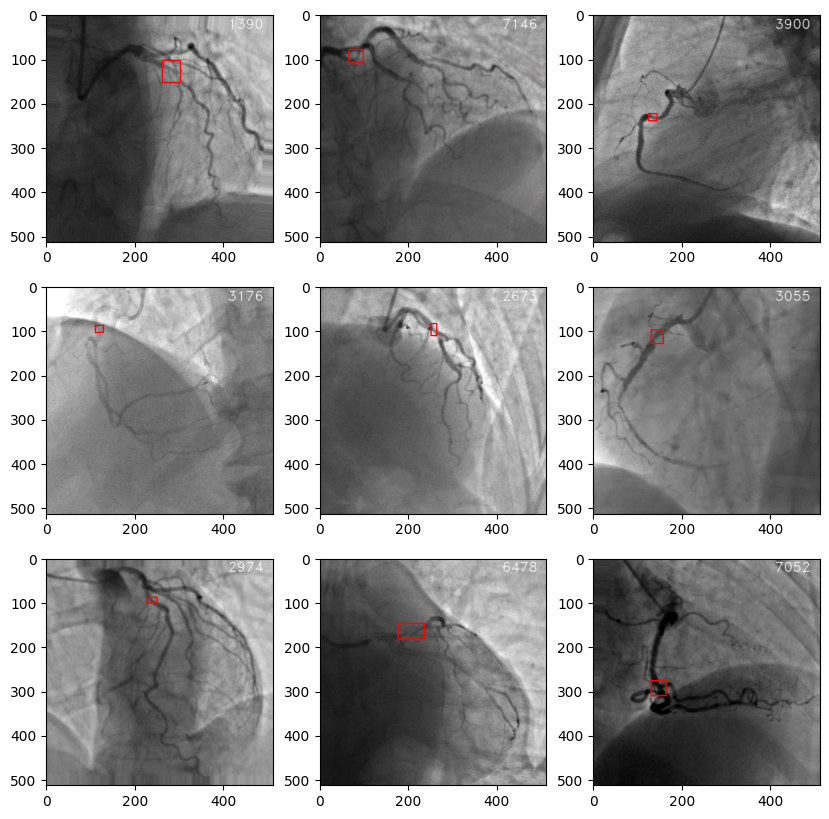

In [8]:
train_visualize_dataset = get_train_dataset(visualize=True)
print("Train set visualziation: ")
visualize_dataset(train_visualize_dataset, config.NUM_SAMPLES_TO_VISUALIZE)

Test set visualization: 


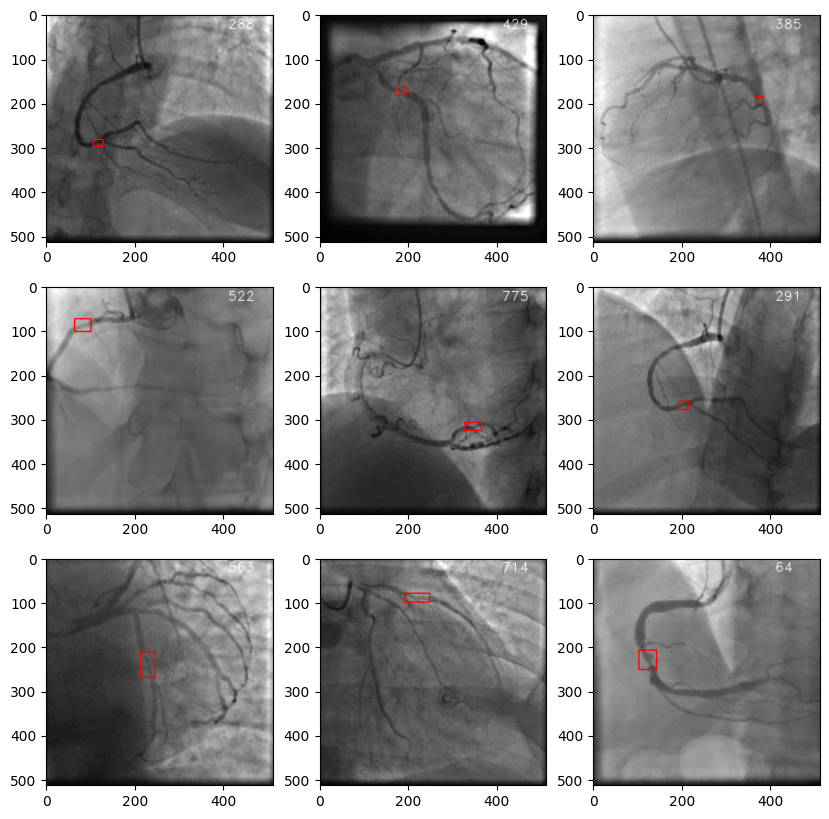

In [9]:
test_visualize_dataset = get_test_dataset(visualize=True)
print("Test set visualization: ")
visualize_dataset(test_visualize_dataset, config.NUM_SAMPLES_TO_VISUALIZE)

In [15]:
# functions must be called from another file due to some error
if __name__ == '__main__':
    train_dataset = datasets.get_train_dataset()
    train_data_loader = datasets.create_train_loader(train_dataset)
    valid_dataset = datasets.get_test_dataset()
    valid_data_loader = datasets.create_test_loader(valid_dataset)
    
    model = fast_rcnn.create_model(num_classes=config.NUM_CLASSES)
    model = model.to(config.DEVICE)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
    
    train_loss_hist = utils.Averager()
    val_loss_hist = utils.Averager()
    save_best_model = utils.SaveBestModel()
    
    train_loss_list = []
    val_loss_list = []
    
    MODEL_NAME = 'FasterRCNN_ResNet50'
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {config.NUM_EPOCHS}")
        
        train_loss_hist.reset()
        val_loss_hist.reset()
    
        start = time.time()
    
        print('Training')
        progress_bar = tqdm.tqdm(train_data_loader, total=len(train_data_loader))
        for i, data in enumerate(progress_bar):
            optimizer.zero_grad()
            images, targets = data

            images = list(image.to(config.DEVICE) for image in images)
            targets = [{k: v.to(config.DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            train_loss_list.append(loss_value)
            train_loss_hist.send(loss_value)
            
            losses.backward()
            optimizer.step()
        
            # update the loss value beside the progress bar for each iteration
            progress_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
        # validation
        print('Validating')
        progress_bar = tqdm.tqdm(valid_data_loader, total=len(valid_data_loader))
        for i, data in enumerate(progress_bar):
            images, targets = data
    
            images = list(image.to(config.DEVICE) for image in images)
            targets = [{k: v.to(config.DEVICE) for k, v in t.items()} for t in targets]
    
            with torch.no_grad():
                loss_dict = model(images, targets)
    
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_list.append(loss_value)
            val_loss_hist.send(loss_value)
    
            progress_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
        
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    
        save_best_model(
            val_loss_hist.value, epoch, model, optimizer
        )
        utils.save_model(epoch, model, optimizer)
        utils.save_loss_plot(config.OUT_DIR, train_loss_list, val_loss_list)
            
        # sleep for 2 seconds after each epoch
        time.sleep(2)


EPOCH 1 of 3
Training


  0%|          | 0/25 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [17]:
model = fast_rcnn.create_model(num_classes=config.NUM_CLASSES)
checkpoint = torch.load('./outputs/best_model.pth', map_location=config.DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(config.DEVICE).eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
DIR_TEST = './data/dataset/'
test_images = glob.glob(f"{DIR_TEST}/*.bmp")[50:3030:300]
print(f"Test instances: {len(test_images)}")

Test instances: 10


In [35]:
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.1
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0 

In [36]:
COLORS = np.random.uniform(0, 255, size=(len(config.CLASSES), 3))

for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).to(config.DEVICE)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(config.DEVICE))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [config.CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        print(pred_classes)
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[config.CLASSES.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)
        cv2.imshow('Prediction', orig_image)
        cv2.waitKey(1)
        cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

['Stenosis', 'Stenosis', 'Stenosis', 'Stenosis']
Image 1 done...
--------------------------------------------------
['Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis']
Image 2 done...
--------------------------------------------------
['Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis', 'Stenosis']
Image 3 done...
--------------------------------------------------
Image 4 done...
--------------------------------------------------
Image 5 done...
--------------------------------------------------
['Stenosis', 'Stenosis', 'Stenosis', 'Stenosis']
Image 6 done...
--------------------------------------------------
['Stenosis', 'Stenosis', 'Stenosis', 'Stenosis']
Image 7 done...
--------------------------------------------------
['Stenosis', 'Stenosis']
Image 8 done...
--------------------------------------------------
['Stenosis', '